In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


tf.enable_eager_execution()

### 1. Генерация данных

In [0]:
import datetime
from random import randrange
from datetime import timedelta

def get_random_date(start, end):
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return (start + timedelta(seconds=random_second)).replace(hour=0, minute = 0, second=0)


FORMATS = ['%d %b %Y', '%d %B %Y', '%B %dth, %Y', '%b %d, %Y', 
           '%d/%m/%Y', '%d/%m/%y', '%d-%b-%y', '%d.%m.%Y']

TARGET_FORMAT = '%d-%m-%Y'

def get_dataset(fst_dt, snd_dt, fmt_dt, num=10000):
    fst_d = datetime.datetime.strptime(fst_dt, fmt_dt)
    snd_d = datetime.datetime.strptime(snd_dt, fmt_dt)
    dataset = []
    for i in range(num):
        date_format = random.choice(FORMATS)
        rand_dt = get_random_date(fst_d, snd_d)
        t = (datetime.datetime.strftime(rand_dt, date_format), 
            datetime.datetime.strftime(rand_dt, TARGET_FORMAT))
        dataset.append(t)
    return dataset
    
dataset = get_dataset('1/1/2017', '1/1/2019', '%m/%d/%Y')

In [4]:
dataset[:10]

[('17 Aug 2018', '17-08-2018'),
 ('October 29th, 2018', '29-10-2018'),
 ('18 October 2018', '18-10-2018'),
 ('22 April 2017', '22-04-2017'),
 ('13.12.2017', '13-12-2017'),
 ('25 August 2017', '25-08-2017'),
 ('24-Sep-18', '24-09-2018'),
 ('17/02/17', '17-02-2017'),
 ('Jun 18, 2018', '18-06-2018'),
 ('07/02/2018', '07-02-2018')]

### 2. Создаем вспомогательные классы для word2index, index2word

In [0]:
# в нашем случае word является символом
class Lang(object):
    def __init__(self, name):
        self.name = name
        self.word2index = {"<pad>": 0, "SOS": 1, "EOS": 2}
        self.SOS = "SOS"
        self.EOS = "EOS"
        self.pad = "<pad>"
        self.index2word = {0: "<pad>", 1: "SOS", 2: "EOS"}
        self.n_words = 3  # SOS and EOS and pad

    def add_sentence(self, sentence):
        for word in list(sentence):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1

    def fit(self, sentences):
        for sent in sentences:
          self.add_sentence(sent)
  
    def transform(self, sentences):
        res = []
        for sent in sentences:
            sent = [self.word2index[self.SOS]] + [self.word2index[w] for w in sent] + [self.word2index[self.EOS]]
            res.append(sent)
        return res
            

In [0]:
def create_keras_data(inp_lang_name="human", targ_lang_name="iso", size=10000):
  pairs = get_dataset('1/1/2017', '1/1/2019', '%m/%d/%Y', size)
  input_tensor = [x[0] for x in pairs]
  target_tensor = [x[1] for x in pairs]
  
  
  inp_lang = Lang(inp_lang_name)
  inp_lang.fit(input_tensor)
  targ_lang = Lang(targ_lang_name)
  targ_lang.fit(target_tensor)
  
  input_tensor = inp_lang.transform(input_tensor)
  target_tensor = targ_lang.transform(target_tensor)
  
  max_length_inp = max(map(len, input_tensor))
  max_length_tar = max(map(len, target_tensor))
  
  input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                               maxlen=max_length_inp,
                                                               padding='post',
                                                               value=inp_lang.word2index[inp_lang.pad])
  
  target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                maxlen=max_length_tar, 
                                                                padding='post',
                                                                value=targ_lang.word2index[targ_lang.pad])
  return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [0]:
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = create_keras_data()

In [8]:
input_tensor.shape, target_tensor.shape, max_length_inp, max_length_targ, inp_lang.n_words, targ_lang.n_words

((10000, 22), (10000, 12), 22, 12, 44, 14)

#### Split on train and test

In [0]:
from sklearn.model_selection import train_test_split


input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1)

In [10]:
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(9000, 9000, 1000, 1000)

In [11]:
inp_lang.n_words

44

In [12]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
embedding_dim = 256
units = 256
vocab_inp_size = inp_lang.n_words
vocab_tar_size = targ_lang.n_words

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.apply(tf.contrib.data.batch_and_drop_remainder(BATCH_SIZE))

Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.


### 3. Seq2Seq Model without attention
- модель, состоящая из двух RNN: encoder и decoder.  Encoder считывает предложение и выдает вектор (закодированное предложение), decoder считывает этот вектор и генерирует предложение.
- в конец исходного предложения добавляем EOS-символ (его векторное представление, получающееся после применения encoder - и есть вектор, который будем подавать в decoder)
- на вход decoder в качестве первого символа подается SOS-символ, а в качестве начального скрытого состояния подается эмбеддинг EOS-символа из encoder

In [0]:
def gru(units, return_sequences=True):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=return_sequences, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

#### Write encoder

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        <your code here>
        
    def call(self, x, hidden=None):
        <your code here>
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

#### Write decoder

In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        <your code here>

    def call(self, x, hidden, enc_output):
        # enc_output (batch_size, max_length, enc_hidden)
        # hidden (batch_size, enc_hidden)
        # enc_output (64, 22, 256) hidden (64, 256) x (64, 1, 256)
        
        
        # output shape == (batch_size, vocab)
        <your code here>
        
        


    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))


In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

#### Define optimizer and loss

Implement masked loss.

In [0]:
optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
  mask = <your code here>
  loss_ = <your code here>
  return tf.reduce_mean(loss_)

#### Evaluate

In [0]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    inputs = inp_lang.transform([sentence])[0]

    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2index[targ_lang.SOS]], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_out)

        predicted_id = tf.multinomial(tf.exp(predictions), num_samples=1)[0][0].numpy()

        result += targ_lang.index2word[predicted_id]

        if targ_lang.index2word[predicted_id] == targ_lang.EOS:
            return result, sentence
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [0]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))

In [0]:
translate("05 October 2017", encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: 05 October 2017
Predicted translation: SOS-661<pad>11<pad>795


#### Training loop

In [0]:
import time
import numpy as np


epochs=100
plot_every = 5
plot_losses = []


for epoch in range(epochs):
    start = time.time()

    hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0

        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden

            dec_input = tf.expand_dims([targ_lang.word2index[targ_lang.SOS]] * BATCH_SIZE, 1)       

            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)

                loss += loss_function(targ[:, t], predictions)

                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)

        total_loss += (loss / int(targ.shape[1]))

        variables = encoder.variables + decoder.variables

        gradients = tape.gradient(loss, variables)

        optimizer.apply_gradients(zip(gradients, variables), tf.train.get_or_create_global_step())

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         loss.numpy() / int(targ.shape[1])))

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss/len(input_tensor)))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    translate("05 October 2017", encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
    translate("December 17th, 2022", encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
    
    print()
    plot_losses.append(total_loss)
    

### 4. The Seq2Seq Model with attention

## Write the encoder and decoder model

Here, we'll implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://www.tensorflow.org/tutorials/seq2seq). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://www.tensorflow.org/tutorials/seq2seq#background_on_the_attention_mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence.

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*. 

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

We're using *Bahdanau attention*. Lets decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU
  
The shapes of all the vectors at each step have been specified in the comments in the code:

#### Модель с attention decoder

In [0]:
class AttentionDecoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(AttentionDecoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        <your code here>
        
        # used for attention
        <your code here>
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, hidden_size)
        score = <your code here>
        
        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = <your code here>
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = <your code here>
        context_vector = <your code here>
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = <your code here>
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = <your code here>
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * max_length, vocab)
        x = <your code here>
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = AttentionDecoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [0]:
optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)

#### Rewrite evaluation funcs

In [0]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    # sentence = preprocess_sentence(sentence)

    # inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = inp_lang.transform([sentence])[0]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2index[targ_lang.SOS]], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.multinomial(tf.exp(predictions), num_samples=1)[0][0].numpy()

        result += targ_lang.index2word[predicted_id]

        if targ_lang.index2word[predicted_id] == targ_lang.EOS:
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
import matplotlib.ticker as ticker


# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):

    # Set up figure with colorbar
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attention, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + list(sentence) +
                       ['EOS'], rotation=90)
    ax.set_yticklabels([''] + list(predicted_sentence.replace("EOS", "")) + ["EOS"])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


In [0]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ, is_plot_attn=False):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    if is_plot_attn:
      attention_plot = attention_plot
      plot_attention(attention_plot, sentence, result)

#### Train model with attention

In [0]:
EPOCHS = 20
plot_losses = []


for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2index[targ_lang.SOS]] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)

        total_loss += (loss / int(targ.shape[1]))
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
      
        optimizer.apply_gradients(zip(gradients, variables), tf.train.get_or_create_global_step())

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         loss.numpy() / int(targ.shape[1])))
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss/len(input_tensor)))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    translate("05 October 2017", encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
    translate("December 17th, 2022", encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
    print()
    
    plot_losses.append(total_loss)

#### Plot attention

Input: 05 October 2017
Predicted translation: 05-10-2017EOS


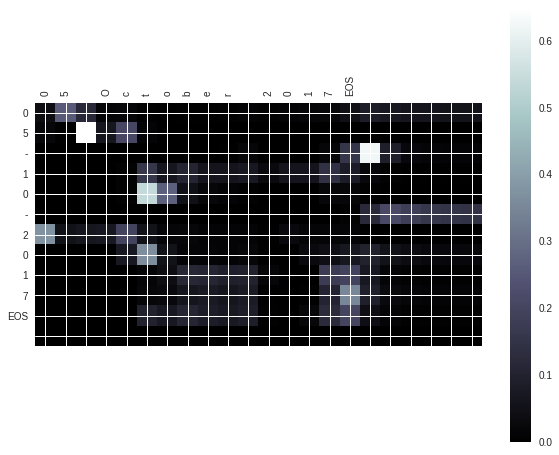

In [0]:
translate("05 October 2017", encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ, True)

Input: 10-10-2017
Predicted translation: 10-10-2017EOS


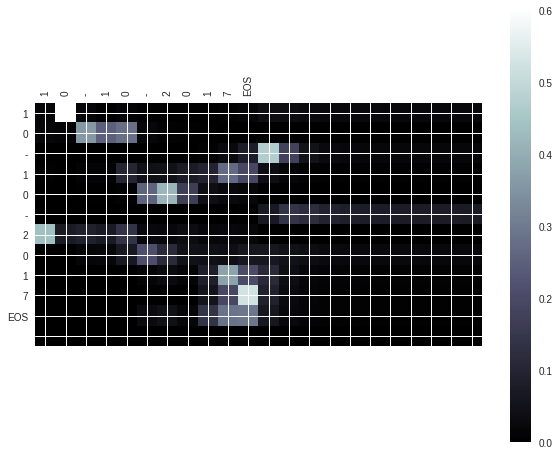

In [0]:
translate("10-10-2017", encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ, True)

Input: 10 10 2020
Predicted translation: 10-01-2018EOS


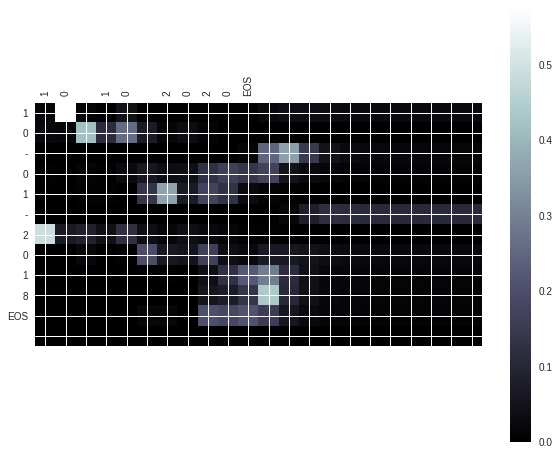

In [0]:
translate("10 10 2020", encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ, True)